In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import skimage

c:\Users\harsh\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
!ls DRIVE/training/images

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!ls DRIVE/training/mask
# We are not using masks because we can generate them using OTSU ourselves too for ROI

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!ls DRIVE/training/1st_manual

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
IMG_INDEX=21

### Reading image

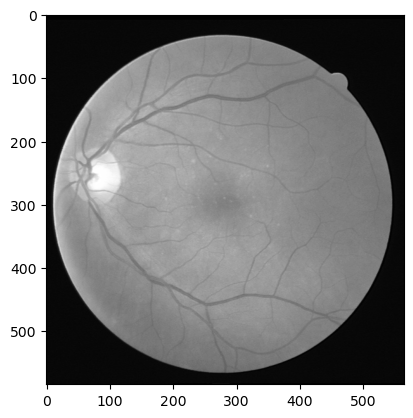

In [7]:
img = cv.imread(f"DRIVE/training/images/{IMG_INDEX}_training.tif")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")

## Pre-processing

### Green channel extraction

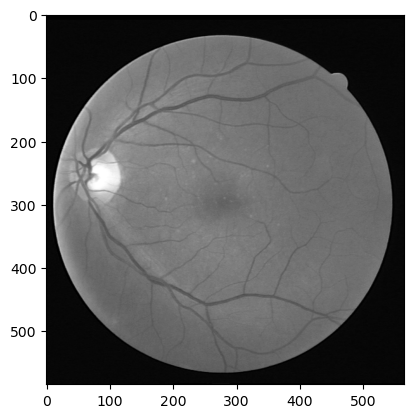

In [8]:
b, g, r = cv.split(img)
img_green = g
plt.imshow(img_green, cmap="gray")

### ROI Extraction (OTSU)

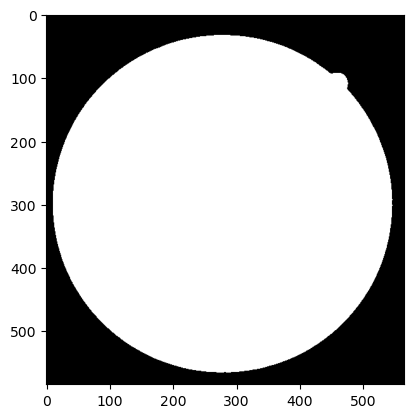

In [9]:
blur = cv.GaussianBlur(img_green,(5,5),0)
_,mask = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(mask, cmap="gray")

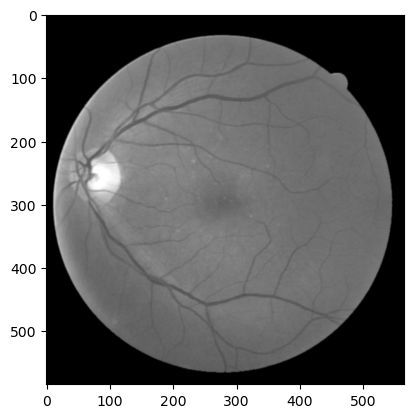

In [10]:
img_mask = cv.bitwise_and(img_green,img_green, mask=mask)
img_mask = cv.GaussianBlur(img_mask, (3,3), 0)
plt.imshow(img_mask, cmap="gray")

### CLAHE Histogram Equalisation

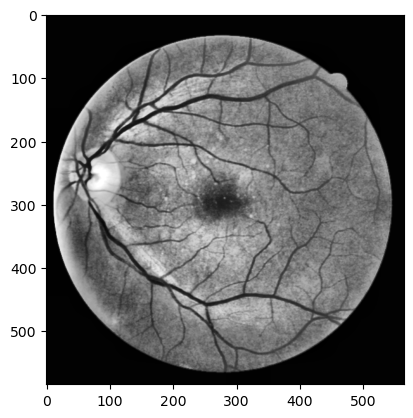

In [11]:
clahe = cv.createCLAHE(clipLimit=7)
img_clahe = clahe.apply(img_mask)
plt.imshow(img_clahe, cmap="gray")

### Image Normalization
Note: The image does not change after normalisation with (0, 255) because CLAHE already does that. If we reduce the normalisation limit to (0, 127) we will observe a difference

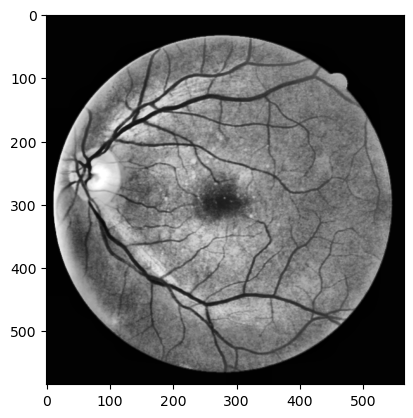

In [12]:
img_norm = cv.normalize(img_clahe, None, 0, 255, cv.NORM_MINMAX)
plt.imshow(img_norm, cmap="gray")

### Morphological Transform (Image Opening)
Image opening is erosion followed by dilusion

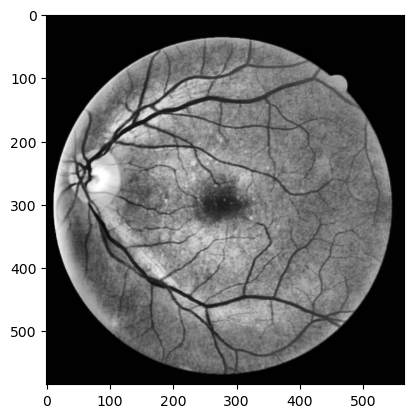

In [13]:
img_erode1 = cv.erode(img_norm, (3,3))
img_open1 = cv.dilate(img_erode1, (3,3))
img_erode2 = cv.erode(img_open1, (5,5))
img_open2 = cv.dilate(img_erode2, (5,5))
img_erode3 = cv.erode(img_open2, (7,7))
img_open3 = cv.dilate(img_erode3, (7,7))
plt.imshow(img_open3, cmap="gray")

## Blood Vessel Enhancement (BVE)

### Frangi Filtering

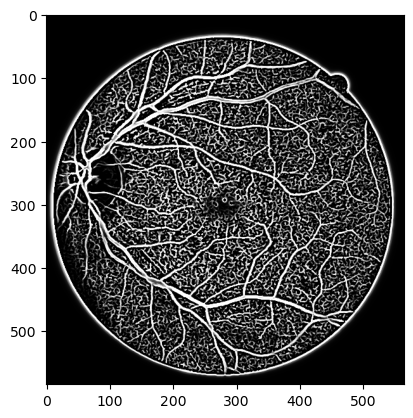

In [14]:
img_frangi = skimage.filters.frangi(img_open3, beta=2, gamma=3.5)
img_frangi = skimage.util.img_as_ubyte(img_frangi)
plt.imshow(img_frangi, cmap="gray")

## Post Processing

### Noise reduction
We find contours then remove small components less than 500 in area

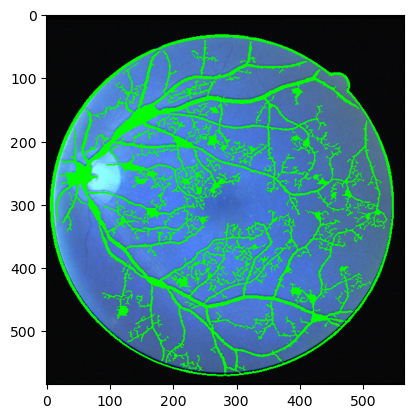

In [15]:
_, img_bw = cv.threshold(img_frangi, 0, 255 ,cv.THRESH_BINARY+cv.THRESH_OTSU)
contours, _ = cv.findContours(img_bw, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

areas = []
ok = []
for contour in contours:
    area = cv.contourArea(contour)
    if area > 500:
        areas.append(area)
        ok.append(contour)

img_test = cv.imread("DRIVE/training/images/21_training.tif")
cv.drawContours(img_test, ok, -1, (0,255,0), cv.FILLED)
plt.imshow(img_test, cmap="gray")

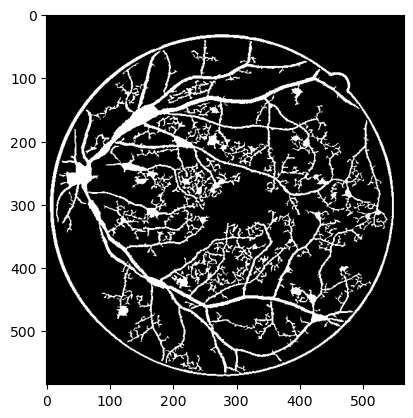

In [16]:
out = np.zeros(img.shape, dtype=np.uint8)
out = cv.cvtColor(out, cv.COLOR_BGR2GRAY)

cv.drawContours(out, ok, -1, (255,255,255), cv.FILLED)
_, out = cv.threshold(out, 0, 255, cv.THRESH_BINARY)
plt.imshow(out, cmap="gray")

### Outer circle removal (Boundary removal)
We observed the mask result is not supposed to have the outer circle.

This outer circle would come in most edge detection methods because it is an edge between the background and the retina, hence, we will remove this by creating a circular mask around the eye and cropping the rest out.

This mask is created by eroding the previous mask

Boundary = A - A(-)B

True

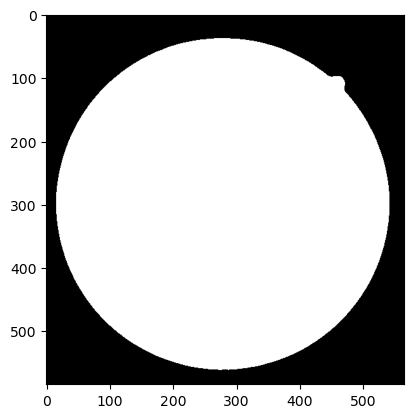

In [17]:
mask_eroded = cv.erode(mask, cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10)))
plt.imshow(mask_eroded, cmap="gray")

# cv.imwrite(f"mask.jpg", mask_eroded)

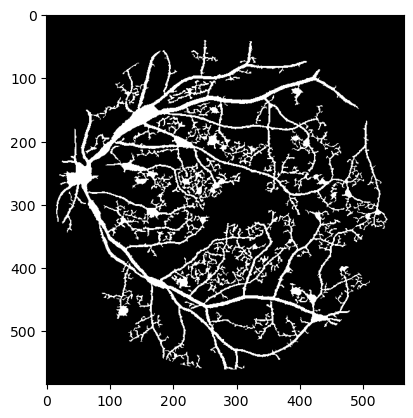

In [18]:
img_masked = cv.bitwise_and(out,out, mask=mask_eroded)
plt.imshow(img_masked,cmap="gray")

In [19]:
cv.imwrite(f"results/final_{IMG_INDEX}.jpg", img_masked)

True

## Result

### Our prediction

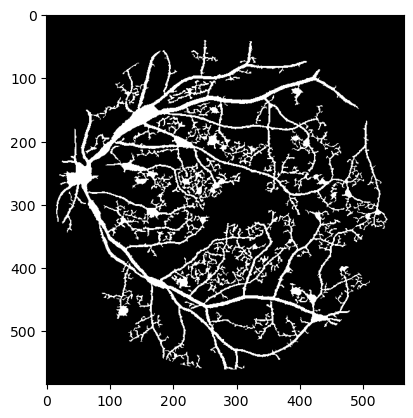

In [20]:
predicted = img_masked
plt.imshow(predicted, cmap="gray")

### Given actual value

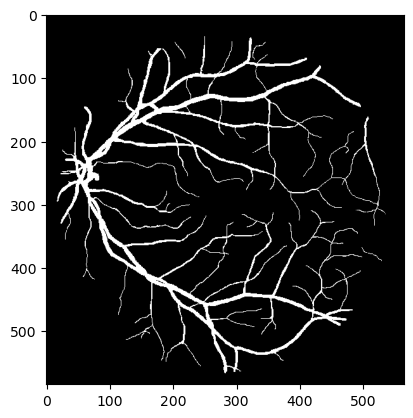

In [21]:
cap = cv.VideoCapture(f"DRIVE/training/1st_manual/{IMG_INDEX}_manual1.gif")
_, actual = cap.read()
actual = cv.cvtColor(actual, cv.COLOR_BGR2GRAY)
_, actual = cv.threshold(actual, 0, 255, cv.THRESH_BINARY)

plt.imshow(actual, cmap="gray")

In [22]:
np.sum(predicted >=0)

329960

In [23]:
np.sum(actual == predicted)

286386

## Analysis

We got same output in **286386 out of 329960 pixels (86.79%)**